In [1]:
import torch 
import numpy as np

from embedders import PhysicsLDSE2C
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from IPython import display

## Point mass

Lets start by creating a simple linear system in a plane, and render some images of this

In [2]:
class PointMass:
    
    def __init__(self,size=5,w=64,dt=0.1,umax=100):
        self.size = size
        self.W = w
        
        self.A = np.eye(2)
        self.B = np.array([[dt,0],
                      [0,dt]])
        
        self.umax = umax/2
        
        self.reset()
        
    def reset(self):
        self.v = np.zeros((2,1))
        self.x = np.random.randint(self.size,self.W-self.size,(2,1))

    def true_dynamics(self,u):

        self.x = np.clip(self.A@self.x + self.B@u,self.size,self.W-self.size) 

        return self.x
    
    def sample_u(self):
        
        return 2*self.umax*np.random.rand(2,1)-self.umax

    def render(self):

        im = np.zeros((3,self.W,self.W))
        xc = np.round(self.x[0]).astype(int)[0]
        yc = np.round(self.x[1]).astype(int)[0]
        im[:,xc-self.size:xc+self.size,yc-self.size:yc+self.size] = 1.0

        return im
    

## Data collection

We'll collect some image and action pairs. We'll also store positions to help analyse the learned latent space

In [3]:
pm = PointMass()

Ntrajs = 10000
seq_len = 3

im_list = []
x_list = []
a_list = []
for k in range(Ntrajs):
    
    pm.reset()
    for j in range(seq_len): 
        
        u = pm.sample_u()
        a_list.append(u/pm.umax)
        x_list.append(pm.true_dynamics(u))

        im = pm.render()
        im_list.append(im)

## Model definition and data loader

Lets create a sequential image dataloader (our model takes in batch x seq len x channel x width x height inputs)

In [4]:
class SeqDataset(Dataset):
    
    def __init__(self, im_list,x_list,a_list,seq_len=8,device ='cuda'):
        
        self.device = device
        self.x = torch.from_numpy(np.vstack(x_list).reshape(-1,seq_len,2))
        self.ims = torch.from_numpy(np.vstack(im_list).reshape(-1,seq_len,3,64,64))
        self.acts = torch.from_numpy(np.vstack(a_list).reshape(-1,seq_len,2))

    def __len__(self):
        return self.ims.shape[0]

    def __getitem__(self, idx):
        
        return self.ims[idx].to(self.device).float(), self.acts[idx].to(self.device).float(), self.x[idx].to(self.device).float()

We'll construct our model, I'm training with a large batch size to help visualise the latent space as it learns, but in the paper we used a very small batch size

In [5]:
img_shape = im_list[0][np.newaxis,:,:].shape
action_dim = 2
state_dim = 2
batch_size = 1000
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_data = SeqDataset(im_list,x_list,a_list,seq_len,device)
dl = DataLoader(training_data, batch_size=batch_size, shuffle=True)

net = PhysicsLDSE2C(img_shape, action_dim, state_dim).to(device)

optimizer = torch.optim.Adam(net.parameters(),lr=1e-4,weight_decay=0)
losses_recon = []
losses_trans = []

## Model training

Let's train our model, and visualise what happens to our latent space as it trains. The colours below correpond to groun truth positions, so red/green indicates a position on an edge, which a mixture between the two indicates diagonals. We also show an example of the three frames used for training, padded with the reconstruction of the target frame.

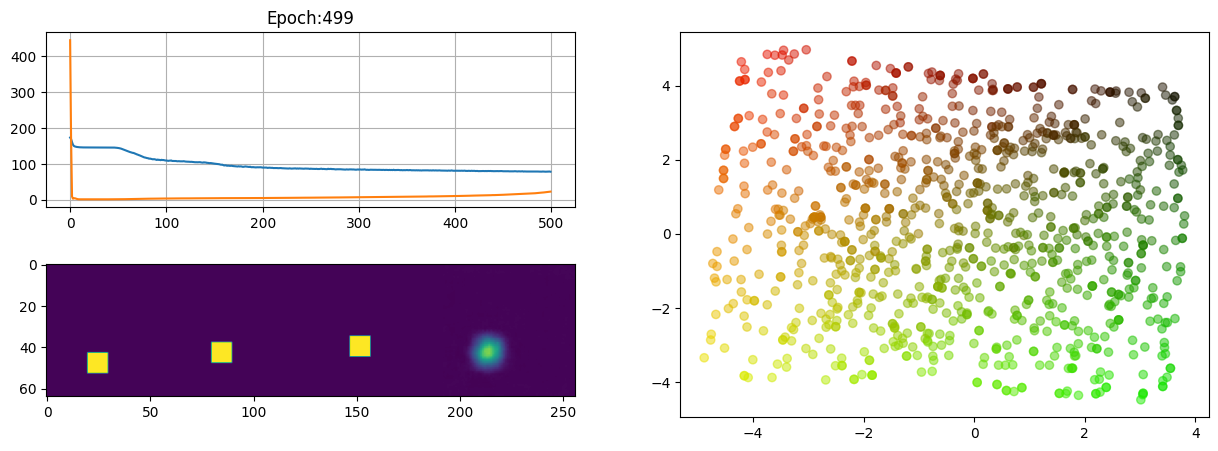

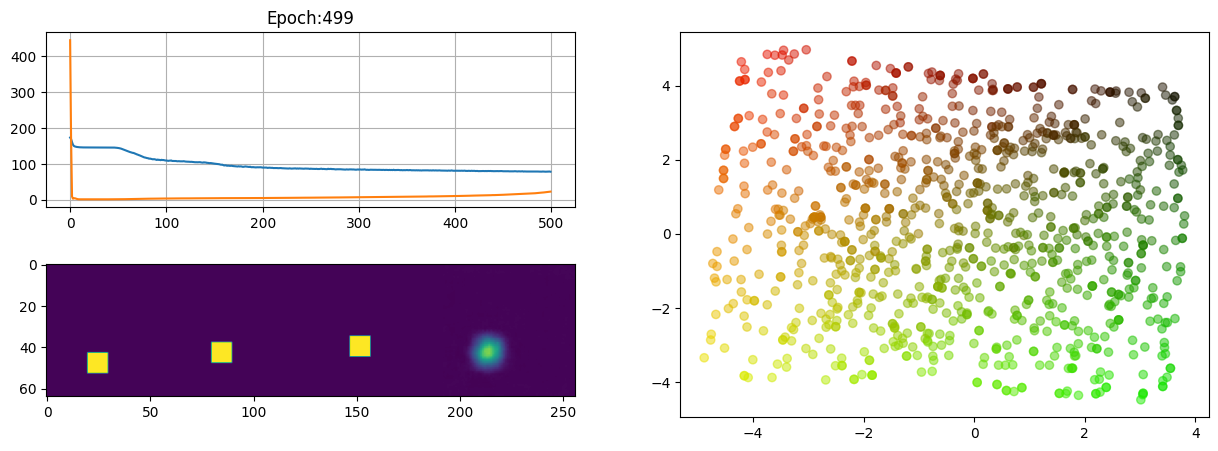

In [6]:
plt.figure(figsize=(15,5))
for epoch in range(epochs):
    
    batch_losses_recon = []
    batch_losses_trans = []
    for im,act,x in dl:
        
        out = net({'img':im,'act':act,'xgt':x},train=True)    
    
        lls = net.compute_losses({'img':im,'act':act,'xgt':x},out,epoch=epoch)    
    
        optimizer.zero_grad()
        
        # Anealing trans kl down seems to help get a decent latent space, otherwise I see some seed dependency
        # and an interesting inversion of the latent space -> the boundaries are near zero, with the space radiating outwards.
        # Would be interesting to explore how to avoid this - clearly finding a globally smooth space by local smooth losses,
        # can allow for this, potentially room for a better objective.
        loss = (1-epoch/epochs)*lls['trans_pos_kl']+epoch/epochs*lls['next_rec']
        
        loss.backward()
        optimizer.step()
        
        batch_losses_recon.append(lls['next_rec'].item())
        batch_losses_trans.append(lls['trans_pos_kl'].item())
    
    
    losses_recon.append(np.mean(batch_losses_recon))
    losses_trans.append(np.mean(batch_losses_trans))
    
    # Visualisation
    plt.clf()
    plt.subplot(2,2,1)
    plt.plot(losses_recon)
    plt.plot(losses_trans)
    plt.grid()
    plt.title("Epoch:"+str(epoch))
    plt.subplot(2,2,3)
    plt.imshow(np.hstack((im[0,:,0,:,:].reshape(-1,64).cpu().T,out['recons'][0,0,:,:].reshape(-1,64).detach().cpu().T)))

    support = out['next_pos_posterior'].mean.detach().cpu().numpy()
    cols = np.clip(x.detach().cpu().numpy(),0,64)
    cl = np.hstack((cols[:,-1,:],np.zeros((cols.shape[0],1))))/64

    plt.subplot(1,2,2)
    plt.scatter(support[:,0],support[:,1],c=cl,alpha=0.5)

    display.clear_output(wait=True)
    display.display(plt.gcf())
    

# Proportional control in latent spaces

Now let's pick a random frame in the scene and show that we can do proportional control to a specific image goal using this nice latent space.

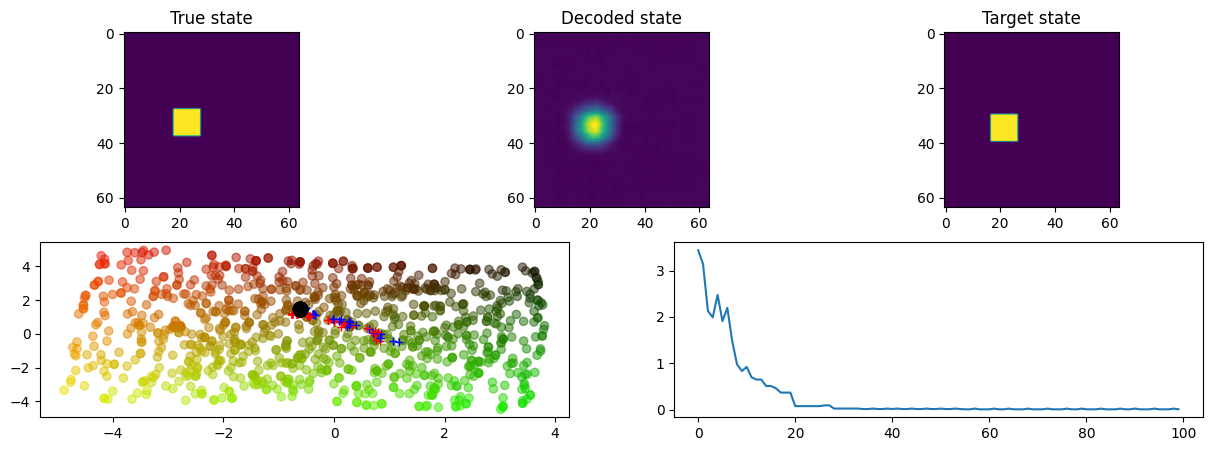

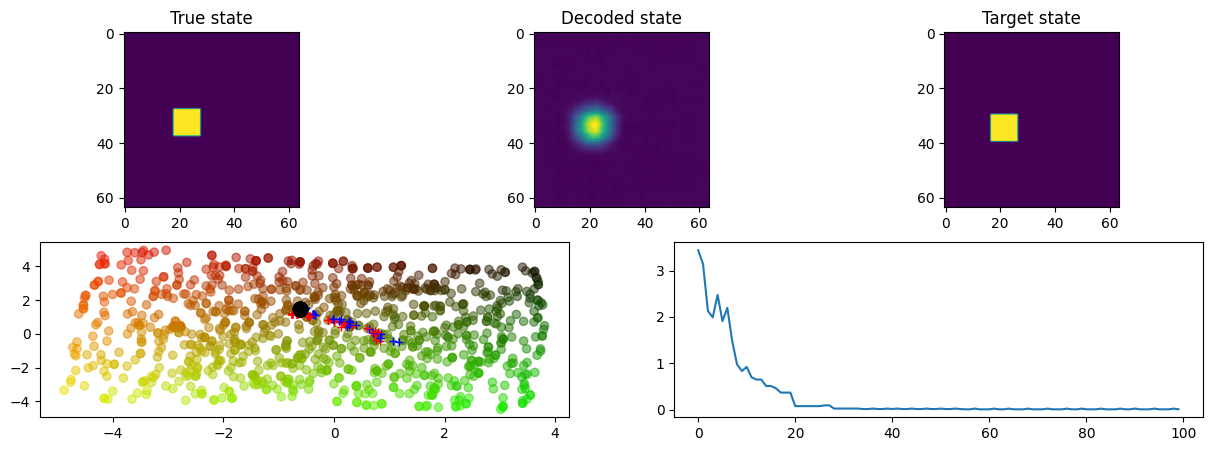

In [7]:
target_frame = im_list[np.random.randint(len(im_list))]
target_state = net.posterior(torch.from_numpy(target_frame)[None,:].to("cuda").float()).mean

Kp = 5

pm.reset()
init_frame = pm.render()

plt.figure(figsize=(15,5))
plt.subplot(2,2,3)
plt.scatter(support[:,0],support[:,1],c=cl,alpha=0.5)

pre_state = net.posterior(torch.from_numpy(init_frame)[None,:].to("cuda").float()).mean

norm_error = []
for j in range(100):
    
    im = pm.render()
    
    # Get current latent state
    state_posterior = net.posterior(torch.from_numpy(im)[None,:].to("cuda").float())
    state = state_posterior.mean
    cov = state_posterior.variance
    
    # Proportional control in latent space
    u = Kp*(state-target_state).reshape(-1,1)
    
    # Latent space error
    norm_error.append(np.mean((state-target_state).detach().cpu().numpy()**2))
    
    # True dynamics
    x = pm.true_dynamics(u.detach().cpu().numpy())
    
    # Check consistency of re-encoded/decoded state (interestingly this is quite poor...)
    st = net.posterior(net.decode(state)).mean
    
    # Visualise trajectories followed
    plt.subplot(2,3,1)
    plt.cla()
    plt.imshow(im[0,:,:])
    plt.title('True state')
    plt.subplot(2,3,2)
    plt.cla()
    plt.imshow(net.decode(state)[0,0,:,:].detach().cpu())
    plt.title('Decoded state')
    plt.subplot(2,3,3)
    plt.cla()
    plt.imshow(target_frame[0,:,:])
    plt.title('Target state')
    plt.subplot(2,2,3)
    u = state.detach().cpu().numpy().ravel()[0]
    v = state.detach().cpu().numpy().ravel()[1]
    a = np.sqrt(cov.detach().cpu().numpy().ravel()[0])*3
    b = np.sqrt(cov.detach().cpu().numpy().ravel()[1])*3
    plt.plot(u,v,'b+')
    plt.plot(st.detach().cpu().numpy().ravel()[0],st.detach().cpu().numpy().ravel()[1],'r+')
    plt.plot(target_state.detach().cpu().numpy().ravel()[0],target_state.detach().cpu().numpy().ravel()[1],'ko',markersize=10)
    
    plt.subplot(2,2,4)
    plt.cla()
    plt.plot(norm_error)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    